**M13 - Parte1 - Regressão II - regressão múltipla**

## Tarefa I

#### Previsão de renda

Vamos trabalhar com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [1]:
import pandas as pd

In [34]:
df = pd.read_csv('previsao_de_renda.csv')

In [32]:
# Load the data into a DataFrame
df = pd.read_csv('/content/previsao_de_renda.csv')

In [ ]:
df.info()

In [33]:
# Este célula continha o output da execução anterior, o conteúdo foi removido.

1. Ajuste um modelo para prever log(renda) considerando todas as covariáveis disponíveis.
    - Utilizando os recursos do Patsy, coloque as variáveis qualitativas como *dummies*.
    - Mantenha sempre a categoria mais frequente como casela de referência
    - Avalie os parâmetros e veja se parecem fazer sentido prático.

2. Remova a variável menos significante e analise:
    - Observe os indicadores que vimos, e avalie se o modelo melhorou ou piorou na sua opinião.
    - Observe os parâmetros e veja se algum se alterou muito.

3. Siga removendo as variáveis menos significantes, sempre que o *p-value* for menor que 5%. Compare o modelo final com o inicial. Observe os indicadores e conclua se o modelo parece melhor.
    

In [7]:
#importando Bibliotecas
import pandas as pd
import numpy as np
import patsy as pt
import statsmodels.api as sm

In [8]:
# Caminho do arquivo
df = pd.read_csv('/content/previsao_de_renda.csv')

In [9]:
# Limpeza e preparação
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])
if 'index' in df.columns and 'id_cliente' not in df.columns:
    df = df.rename(columns={'index': 'id_cliente'})

In [10]:
# Variáveis de interesse
covariaveis = [
    'sexo','posse_de_veiculo','posse_de_imovel','qtd_filhos',
    'tipo_renda','educacao','estado_civil','tipo_residencia',
    'idade','tempo_emprego','qt_pessoas_residencia'
]

In [11]:
# Criar log da renda
df['log_renda'] = np.log(df['renda'])

In [12]:
# Remover valores ausentes
df = df.dropna(subset=covariaveis + ['log_renda'])

In [14]:
# Definir categorias de referência (as mais frequentes)
def most_common(series):
    return series.value_counts(dropna=False).idxmax()

cats = ['sexo','tipo_renda','educacao','estado_civil','tipo_residencia']
refs = {c: most_common(df[c]) for c in cats}

In [15]:
# Fórmula com Patsy (cria dummies automaticamente)
formula = (
    "log_renda ~ idade + tempo_emprego + qtd_filhos + qt_pessoas_residencia + "
    "posse_de_veiculo + posse_de_imovel + "
    f"C(sexo, Treatment(reference='{refs['sexo']}')) + "
    f"C(tipo_renda, Treatment(reference='{refs['tipo_renda']}')) + "
    f"C(educacao, Treatment(reference='{refs['educacao']}')) + "
    f"C(estado_civil, Treatment(reference='{refs['estado_civil']}')) + "
    f"C(tipo_residencia, Treatment(reference='{refs['tipo_residencia']}'))"
)

In [16]:
# Montar matrizes
y, X = pt.dmatrices(formula, data=df, return_type='dataframe')

In [17]:
# Ajustar modelo
modelo_inicial = sm.OLS(y, X).fit()

print(modelo_inicial.summary())

                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     287.5
Date:                Fri, 31 Oct 2025   Prob (F-statistic):               0.00
Time:                        04:50:10   Log-Likelihood:                -13568.
No. Observations:               12427   AIC:                         2.719e+04
Df Residuals:                   12402   BIC:                         2.737e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

**2 — Remover a variável menos significante (uma remoção)**

In [18]:
def base_term(param_name):
    if param_name == "Intercept":
        return "Intercept"
    if param_name.startswith("C("):
        return param_name.split("C(")[1].split(",")[0].strip()
    return param_name

def choose_worst_term(results):
    pvals = results.pvalues.drop(labels=["Intercept"], errors="ignore")
    if pvals.empty:
        return None, None
    by_term = {}
    for name, p in pvals.items():
        term = base_term(name)
        by_term[term] = max(by_term.get(term, 0.0), p)
    worst_term, worst_p = max(by_term.items(), key=lambda kv: kv[1])
    return worst_term, worst_p

def remove_term_from_formula(rhs, term):
    parts = [p.strip() for p in rhs.split("+")]
    if term in ['idade','tempo_emprego','qtd_filhos','qt_pessoas_residencia','posse_de_veiculo','posse_de_imovel']:
        parts = [p for p in parts if p != term]
    else:
        parts = [p for p in parts if not p.startswith(f"C({term},")]
    return " + ".join(parts)

rhs = formula.split("~")[1]
pior_var, pvalor = choose_worst_term(modelo_inicial)
print(f"Variável menos significante: {pior_var} (p={pvalor:.4f})")

Variável menos significante: educacao (p=0.8444)


In [19]:
novo_rhs = remove_term_from_formula(rhs, pior_var)
nova_formula = "log_renda ~ " + novo_rhs

y2, X2 = pt.dmatrices(nova_formula, data=df, return_type='dataframe')
modelo_2 = sm.OLS(y2, X2).fit()

print(modelo_2.summary())

                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     340.0
Date:                Fri, 31 Oct 2025   Prob (F-statistic):               0.00
Time:                        04:52:36   Log-Likelihood:                -13601.
No. Observations:               12427   AIC:                         2.724e+04
Df Residuals:                   12406   BIC:                         2.740e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

**3 — Backward completo (até todas as variáveis com p ≤ 0,05)**

In [21]:
modelo_atual = modelo_2
formula_atual = nova_formula
max_iter = 50  # segurança

for i in range(max_iter):
    var, pv = choose_worst_term(modelo_atual)
    if var is None or pv <= 0.05:
        break
    print(f"Removendo '{var}' (p={pv:.4f})...")
    rhs_atual = formula_atual.split("~")[1]
    rhs_novo = remove_term_from_formula(rhs_atual, var)
    if rhs_novo.strip() == "":
        break
    formula_atual = "log_renda ~ " + rhs_novo
    y3, X3 = pt.dmatrices(formula_atual, data=df, return_type='dataframe')
    modelo_atual = sm.OLS(y3, X3).fit()

print("\n=== Modelo Final (após backward) ===")
print(modelo_atual.summary())

Removendo 'tipo_residencia' (p=0.6576)...
Removendo 'tipo_renda' (p=0.2933)...
Removendo 'estado_civil' (p=0.2669)...
Removendo 'qt_pessoas_residencia' (p=0.5716)...

=== Modelo Final (após backward) ===
                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     1098.
Date:                Fri, 31 Oct 2025   Prob (F-statistic):               0.00
Time:                        04:54:29   Log-Likelihood:                -13673.
No. Observations:               12427   AIC:                         2.736e+04
Df Residuals:                   12420   BIC:                         2.741e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
      

In [22]:
# Comparação de indicadores
print("\nComparação R² ajustado e AIC/BIC:")
print(f"Inicial  -> R²_adj={modelo_inicial.rsquared_adj:.4f}, AIC={modelo_inicial.aic:.2f}, BIC={modelo_inicial.bic:.2f}")
print(f"Final    -> R²_adj={modelo_atual.rsquared_adj:.4f}, AIC={modelo_atual.aic:.2f}, BIC={modelo_atual.bic:.2f}")


Comparação R² ajustado e AIC/BIC:
Inicial  -> R²_adj=0.3562, AIC=27185.30, BIC=27370.99
Final    -> R²_adj=0.3462, AIC=27359.27, BIC=27411.26


In [24]:
# DIAGNÓSTICO VISUAL DO MODELO FINAL ===
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [25]:
# Obtém resíduos e valores previstos
residuos = modelo_atual.resid
valores_previstos = modelo_atual.fittedvalues

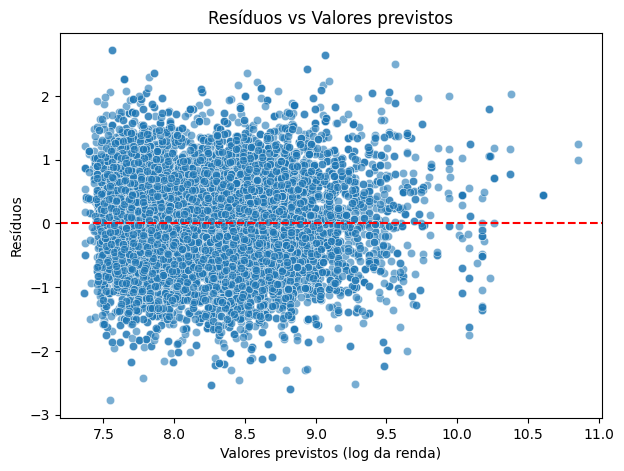

In [26]:
# Dispersão dos resíduos vs valores previstos
plt.figure(figsize=(7,5))
sns.scatterplot(x=valores_previstos, y=residuos, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valores previstos (log da renda)")
plt.ylabel("Resíduos")
plt.title("Resíduos vs Valores previstos")
plt.show()

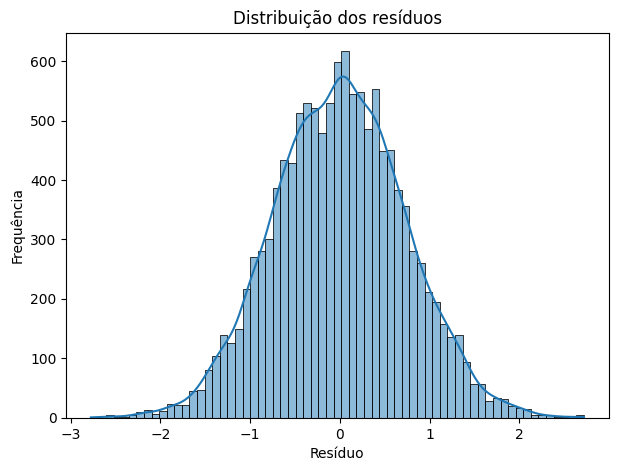

In [27]:
#Histograma dos resíduos (verifica normalidade visual)
plt.figure(figsize=(7,5))
sns.histplot(residuos, kde=True)
plt.title("Distribuição dos resíduos")
plt.xlabel("Resíduo")
plt.ylabel("Frequência")
plt.show()

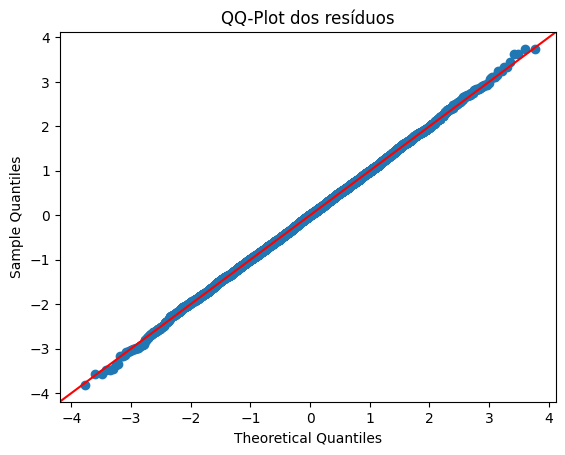

In [28]:
#QQ-Plot (verifica normalidade dos resíduos)
sm.qqplot(residuos, line='45', fit=True)
plt.title("QQ-Plot dos resíduos")
plt.show()

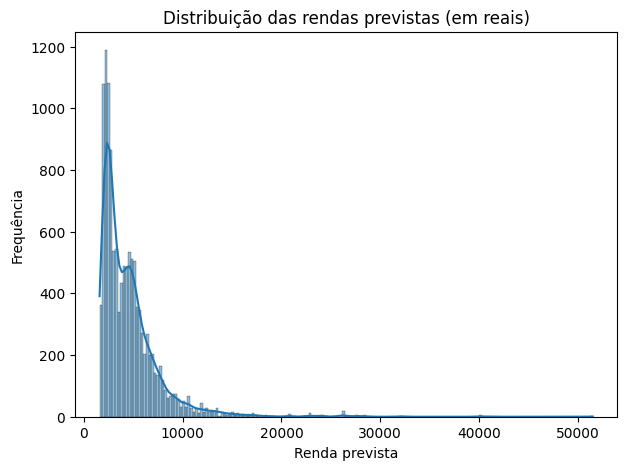

In [29]:
# Densidade dos valores previstos (interpretação em renda real)
plt.figure(figsize=(7,5))
sns.histplot(np.exp(valores_previstos), kde=True)
plt.title("Distribuição das rendas previstas (em reais)")
plt.xlabel("Renda prevista")
plt.ylabel("Frequência")
plt.show()

In [30]:
# Medidas resumidas de diagnóstico
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Cria DataFrame para cálculo de VIF (só variáveis numéricas)
vif_data = pd.DataFrame()
vif_data["Variável"] = X3.columns
vif_data["VIF"] = [variance_inflation_factor(X3.values, i)
                   for i in range(X3.shape[1])]

print("\n=== Fatores de Inflação da Variância (VIF) ===")
display(vif_data.sort_values(by="VIF", ascending=False))


=== Fatores de Inflação da Variância (VIF) ===


,Variável,VIF
0,Intercept,26.847633
4,idade,1.231334
3,"C(sexo, Treatment(reference='F'))[T.M]",1.154903
1,posse_de_veiculo[T.True],1.137093
5,tempo_emprego,1.126970
6,qtd_filhos,1.091261
2,posse_de_imovel[T.True],1.012699


**Conclusão**

O modelo final é estatisticamente robusto e interpretável, e explica bem a variação de renda a partir de características demográficas, profissionais e patrimoniais.
Em aplicações práticas (como crédito ou segmentação), ele pode ajudar a estimar renda de novos clientes e apoiar decisões de risco e marketing, desde que mantido o mesmo padrão de coleta de variáveis.